## Lesson 11 / Lesson 12:
### Exercise: The transient universe 
---

## MCMC:

In [1]:
import emcee
import numpy as np
from matplotlib import pyplot as plt
import scipy as scipy
from scipy import stats
from tqdm.notebook import tqdm
import corner
import seaborn as sns
from astroML.stats import median_sigmaG
%config InlineBackend.figure_format='retina'
c = sns.color_palette('rocket', 5)

In [2]:
file = np.load('transient.npy')

In [3]:
time = file[:, 0]
flux = file[:, 1]
errors = file[:, 2]

In [4]:
# Burst + exponential tail model definition
def burst_f (x, par): # par is a vector containing the 4 parameters characterizing the burst function
    b, A, t_0, alfa = par
    burst = b + A * np.exp(-alfa*(x-t_0))  
    return np.where(x < t_0, b, burst)

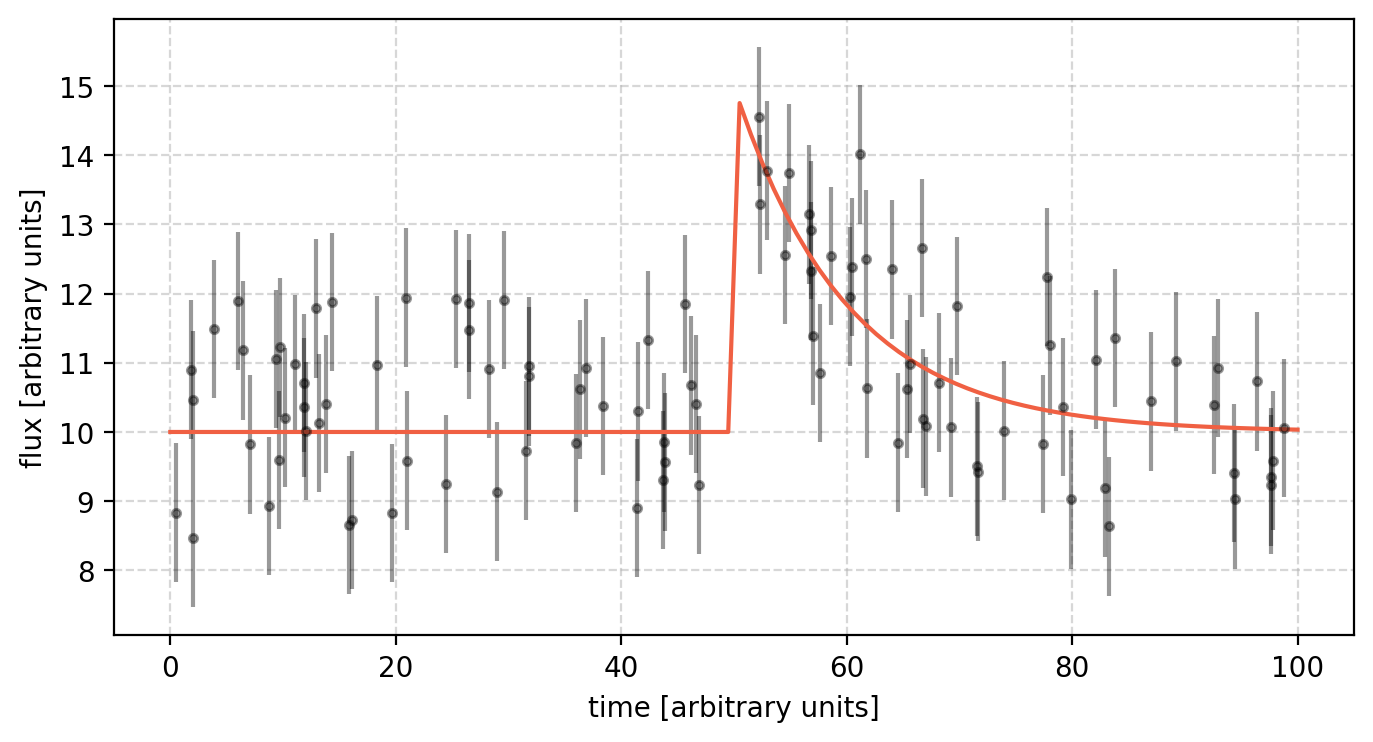

In [5]:
fig = plt.figure(figsize = (8,4))
ax = fig.add_subplot(111)
xgrid = np.linspace(0, 100, 100)

par_guesses = (10, 5, 50, 0.1)

ax.set_xlabel('time [arbitrary units]')
ax.set_ylabel('flux [arbitrary units]')
ax.errorbar(time, flux, yerr=errors, fmt=".", c='black', alpha=0.4)
ax.plot(xgrid, burst_f(xgrid, par_guesses), color=c[3])

ax.grid(True, ls='--', alpha=0.5)

### Defining the likelihood, prior and posterior distributions

We can make the assumption of *gaussianly distributed* data, so that the likelihood can be computed as follows (As we saw in *Lecture 6*):

$$L = \prod_{i=1}^N p(t_i | y_i, M(t_i, \theta), \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \prod_{i=1}^N \exp\Big(-\frac{(y_i - M(t_i,\theta))^2}{2\sigma^2}\Big)$$

$$\ln{L} = \ln\Big(\frac{1}{\sqrt{2\pi\sigma^2}}\Big) - \frac{1}{2}\sum_{i=1}^{N} \frac{(y_i - M(t_i,\theta))^2)}{\sigma^2}$$

where:

$M(t, \theta) = M(t, b, A, t_0, \alpha) = $

>$b$, for $t<t_0$

>$b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

In [6]:
t = np.copy(time)
data = np.copy(flux)
sigma = np.copy(errors)

In [7]:
def LogLikelihood(par):
    model = burst_f(t, par)
    f = (1/sigma**2)*(data - model)**2 
    return (-0.5)*np.sum(f) #Neglecting the const

def Prior(par):
    #uniform prior in (b, A, t_0, log(alpha))
    prior_b = stats.uniform.pdf(par[0], loc=0, scale=50)
    prior_A = stats.uniform.pdf(par[1], loc=0, scale=50)
    prior_t0 = stats.uniform.pdf(par[2], loc=0, scale=100)
    prior_alpha = stats.loguniform.pdf(par[3], np.exp(-5), np.exp(5))
    
    return  prior_b * prior_A * prior_t0 * prior_alpha

def LogPosterior(par):
    
    lprior =  np.log(Prior(par))
    if not np.isfinite(lprior):
        return -np.inf
    else:
        return LogLikelihood(par) + lprior

> `emcee` uses multiple walkers to explore the posterior distribution. We set an initial guess for the parameter (or parameters) for each of those walkers

In [8]:
nwalkers = 15
ndim = 4
burn = 400
nsteps = 10000

In [9]:
# We initialize the parameters
guesses = np.array([10, 5, 50, 0.1])
starting_guesses = guesses + np.random.random((nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior)
sampler.run_mcmc(starting_guesses, nsteps, progress=True) 

print('done')

  0%|                                                 | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_15023/3667719099.py:17: RuntimeWarning: divide by zero encountered in log
  lprior =  np.log(Prior(par))
100%|████████████████████████████████████| 10000/10000 [00:35<00:00, 280.80it/s]

done


### Trace-plots

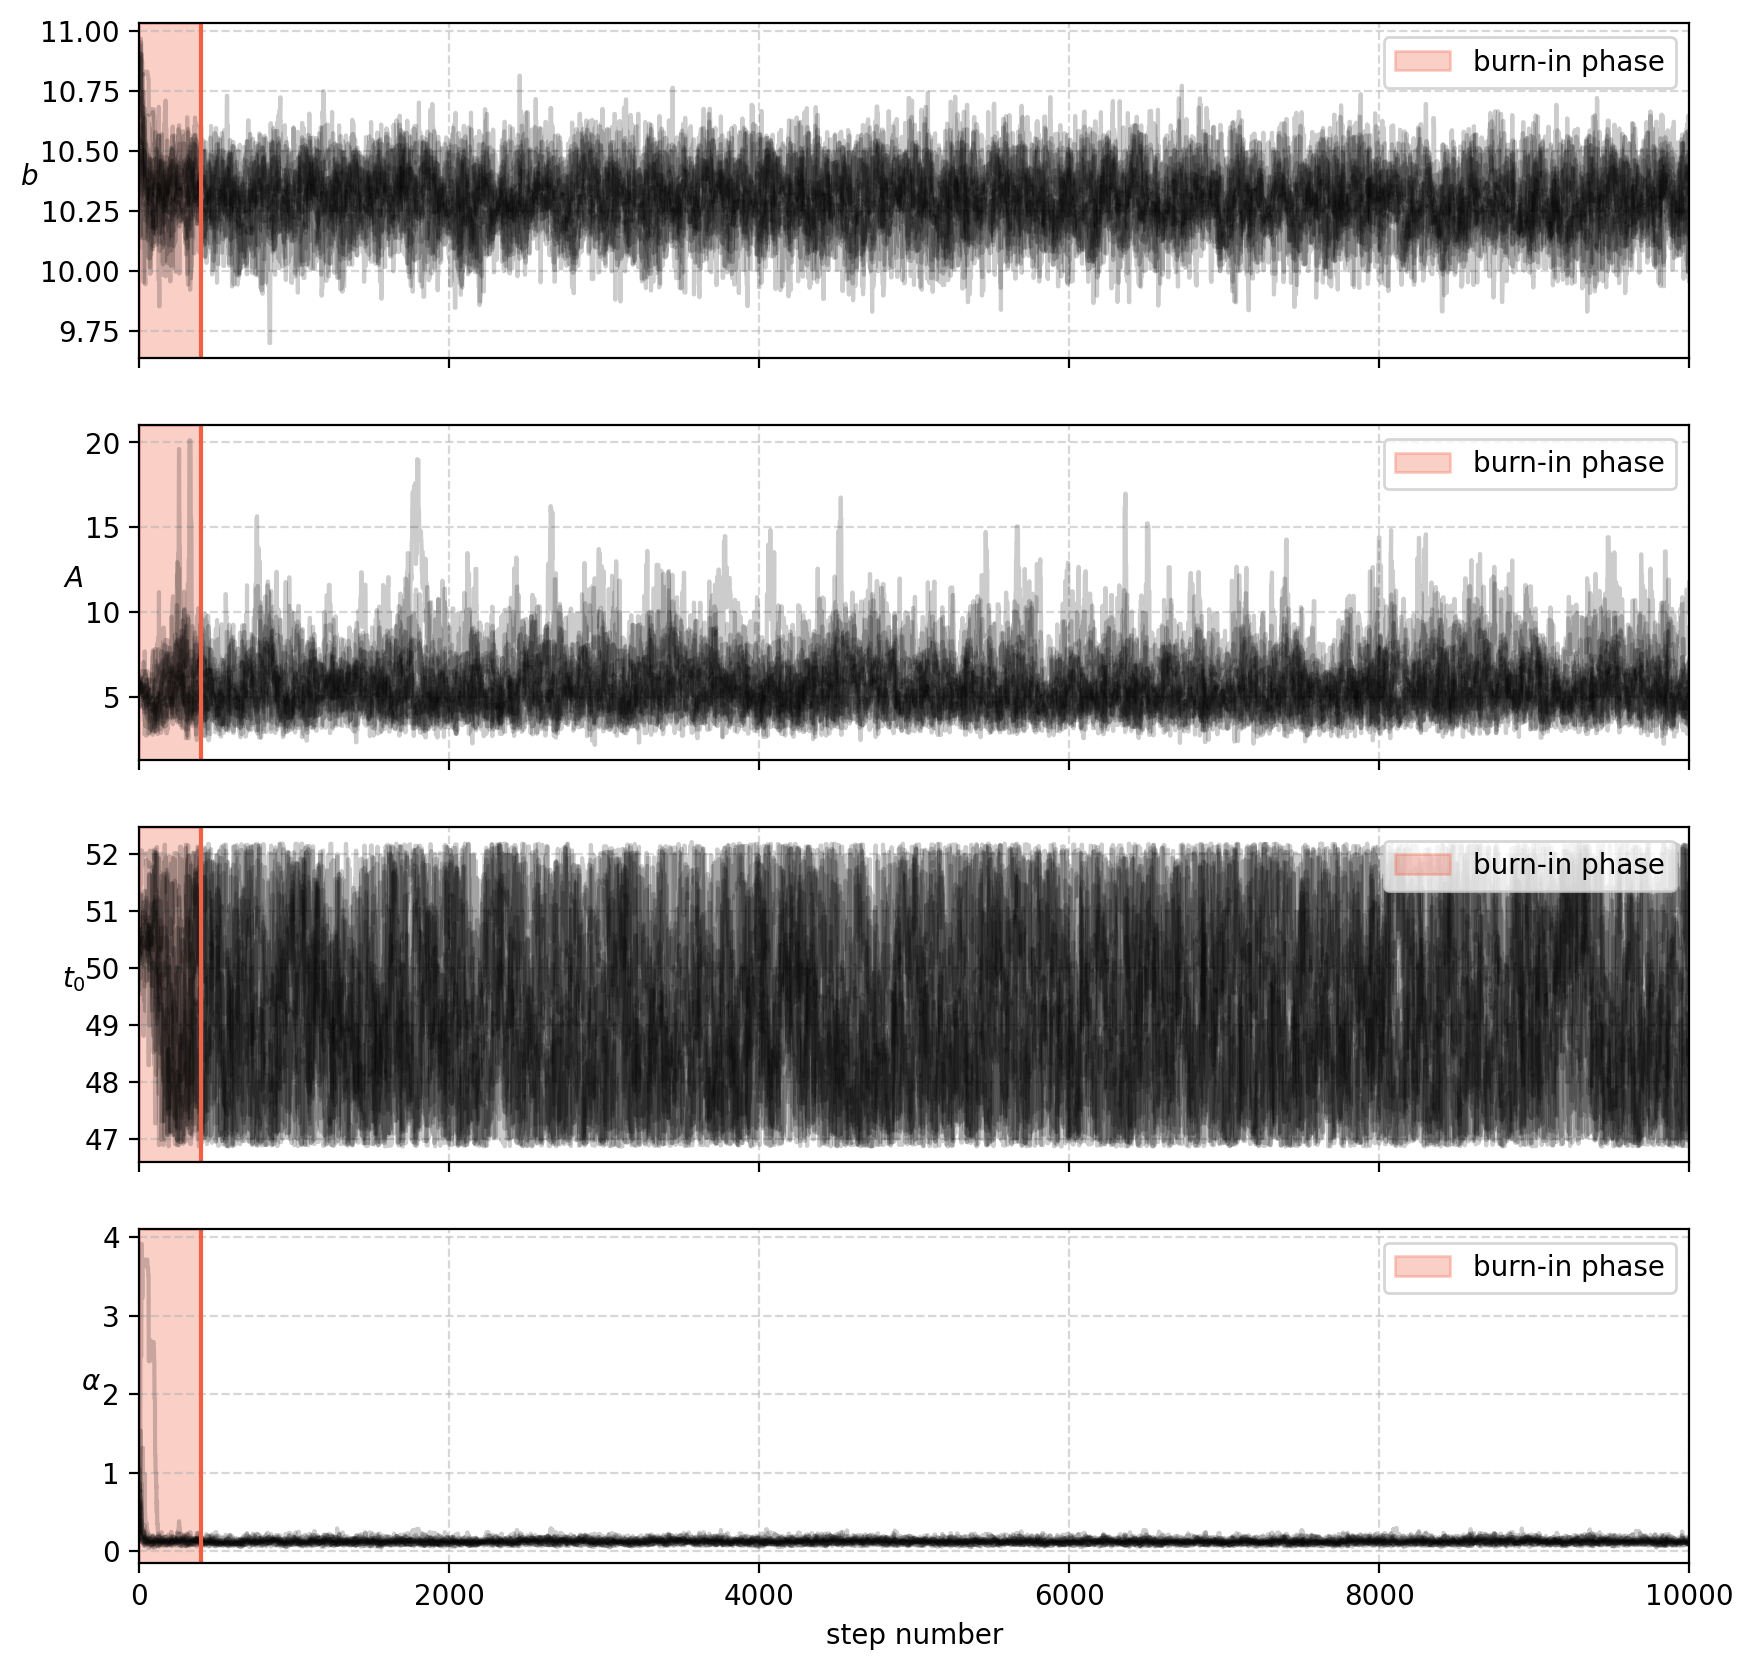

In [10]:
fig, axes = plt.subplots(4, figsize=(10, 10), sharex=True)
samples = sampler.get_chain() #not thinned nor "de-burned"

labels = [r"$b$",r"$A$", r"$t_0$", r"$\alpha$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:,:, i], 'k', alpha=0.2)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], rotation=0)
    ax.grid(True, ls='--', alpha=0.5)
    ax.axvline(burn, color=c[3])
    ax.axvspan(0, burn, color=c[3], alpha=0.3, label=f'burn-in phase')
    ax.legend(frameon=True, loc='upper right')
    
axes[-1].set_xlabel("step number");

### Removing *Burn-in phase* and thinning the chain

In [11]:
tau = sampler.get_autocorr_time()
print(tau)
thin_tau = int(np.mean(tau))
print(thin_tau)

[61.82218981 84.58131929 83.63481709 61.83409505]
72


In [12]:
samples = sampler.get_chain(discard=burn, thin=thin_tau, flat=False)
flat_samples = sampler.get_chain(discard=burn, thin=thin_tau, flat=True)
print(flat_samples.shape)

(1995, 4)


### Corner plot

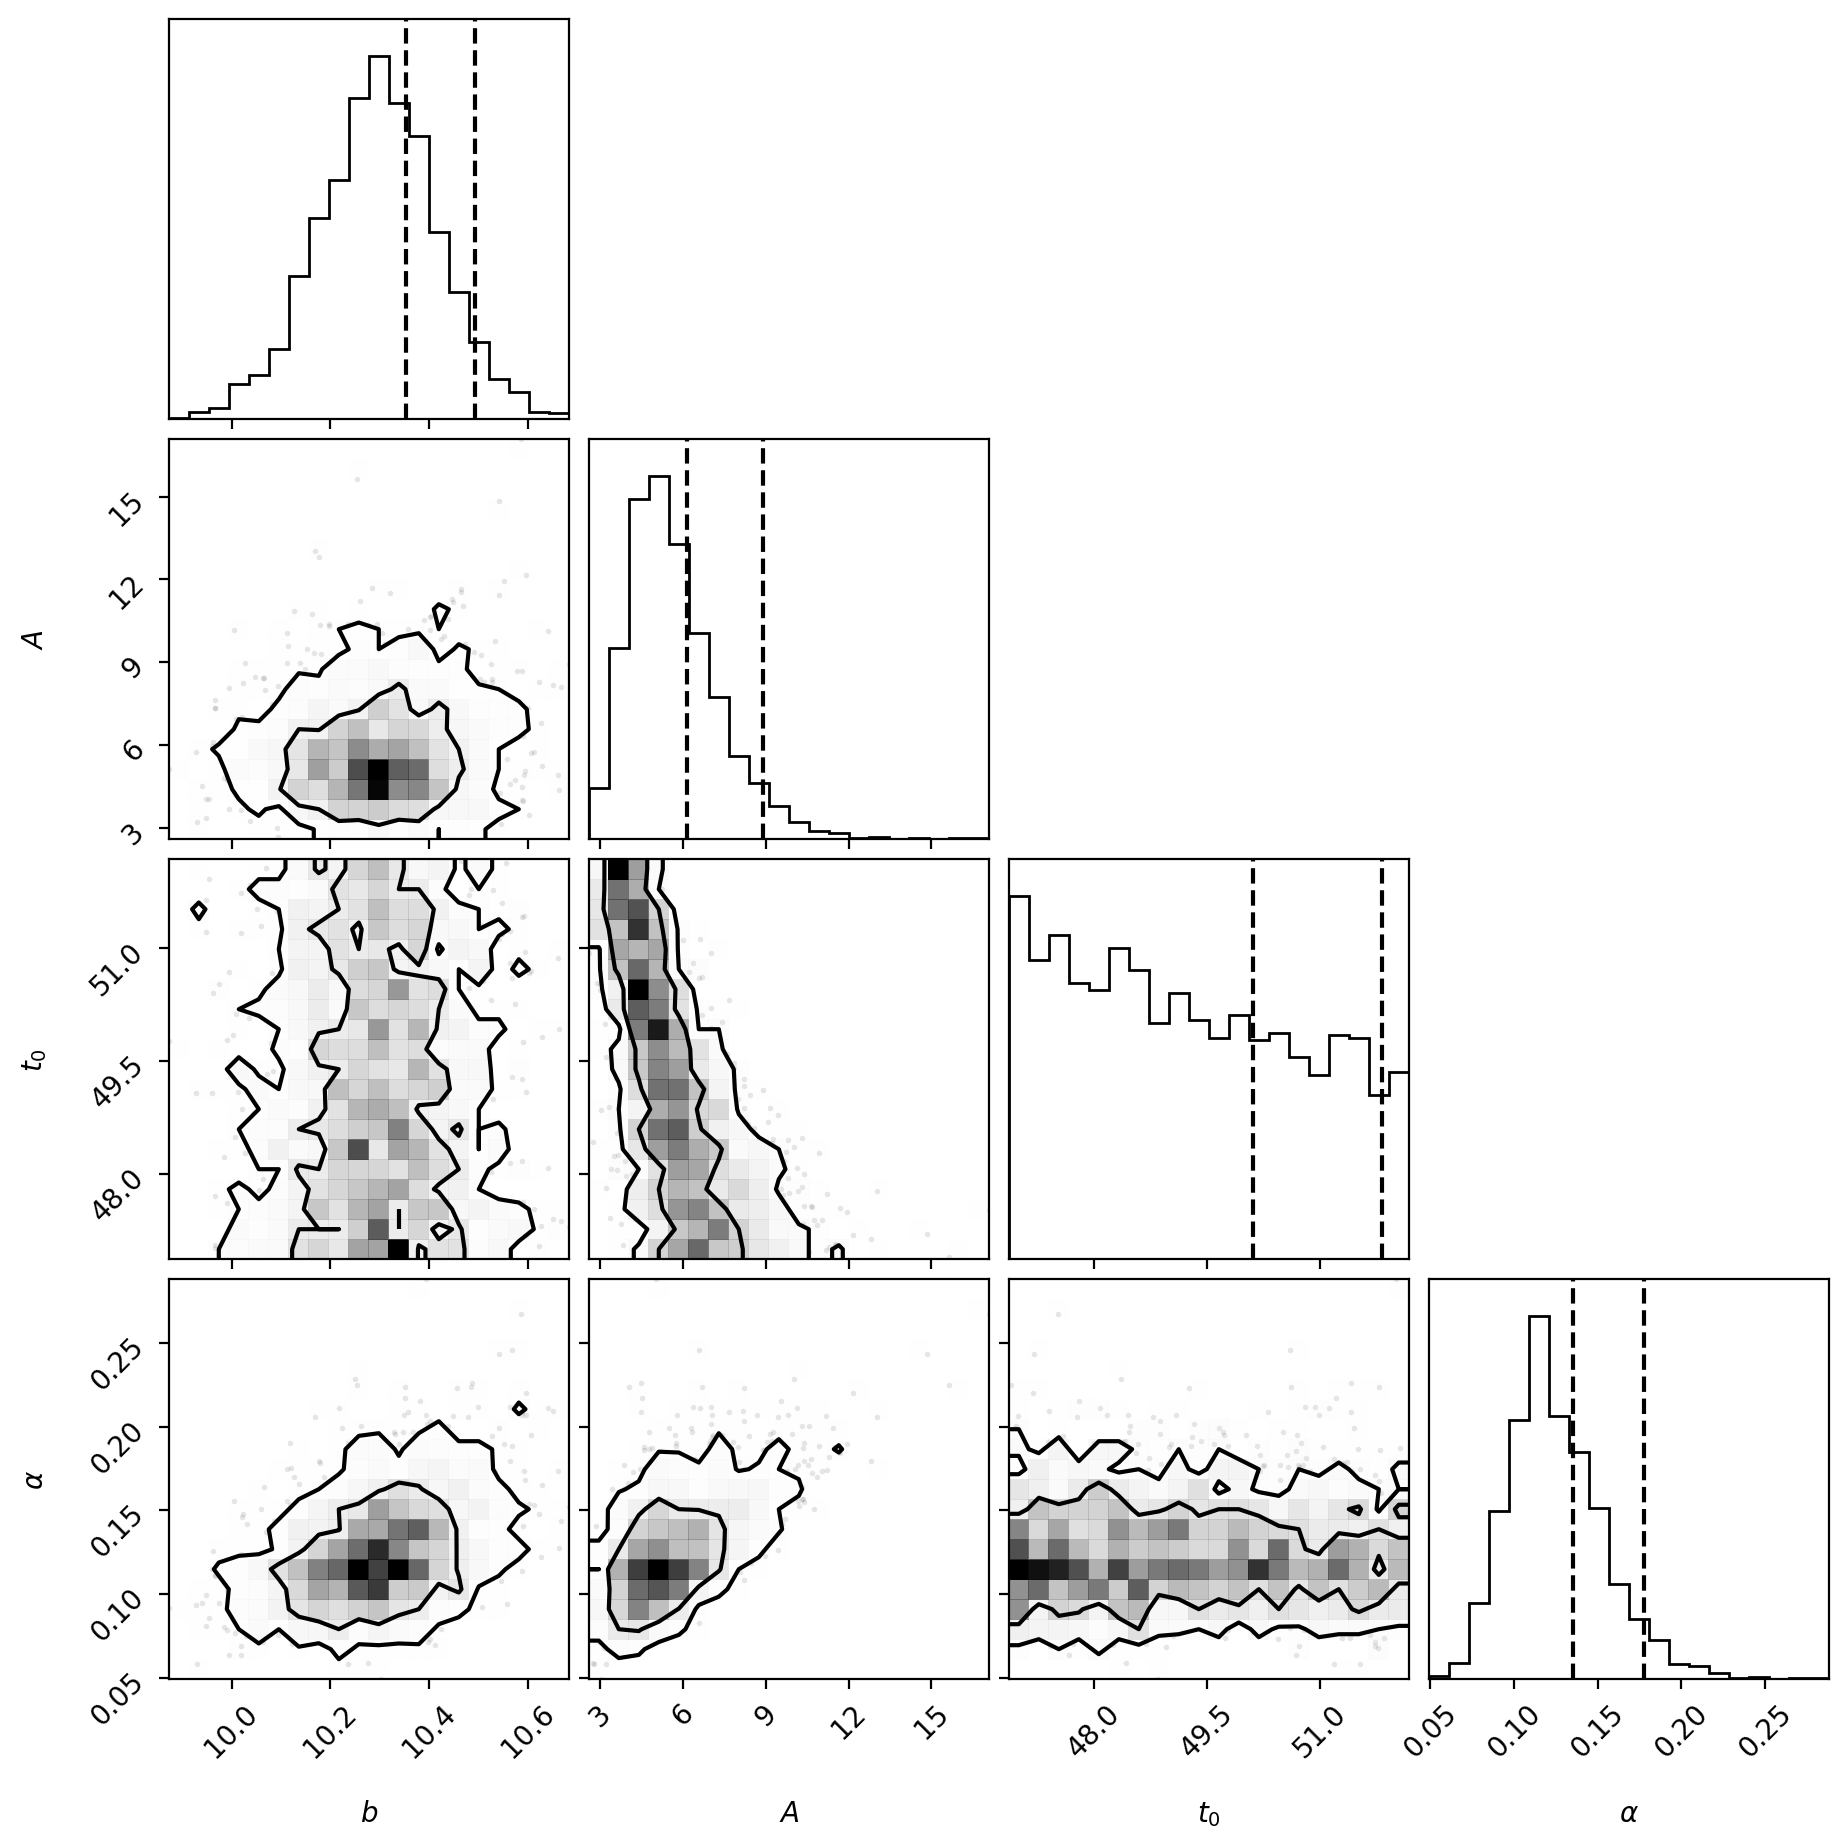

In [13]:
fig = corner.corner(flat_samples, labels=labels, levels=[0.68,0.95], quantiles=[0.68, 0.95]);

---

### Extract 100 random samples from the chain for parameter estimation:

In [14]:
rng = np.random.default_rng()
rand_samples = rng.choice(flat_samples, size=100)

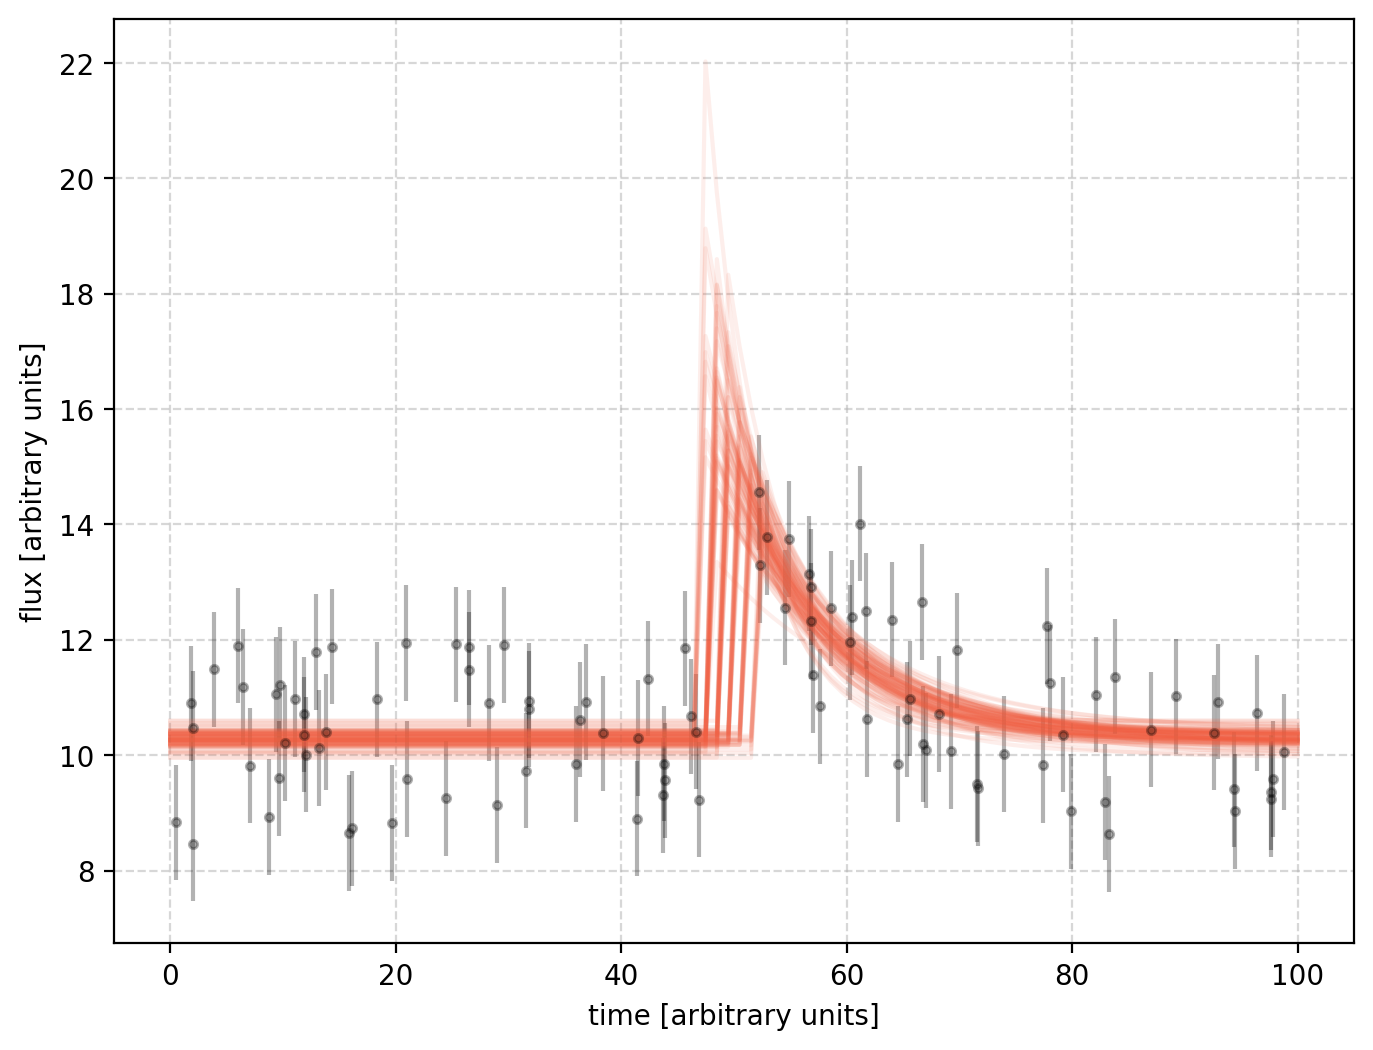

In [15]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)
xgrid = np.linspace(0, 100, 100)

ax.set_xlabel('time [arbitrary units]')
ax.set_ylabel('flux [arbitrary units]')
ax.errorbar(time, flux, yerr=errors, fmt=".", c='black', alpha=0.3)

for sample in rand_samples:
    ax.plot(xgrid, burst_f(xgrid, sample), color=c[3], alpha=0.1)
ax.grid(True, ls='--', alpha=0.5)

In [16]:
medians = median_sigmaG(rand_samples, axis=0)
medians = [val for val in medians]

print(medians[0]) #The medians for the parameters

upper_bounds = np.percentile(rand_samples[:, :], 95, axis=0) - medians[0]
lower_bounds = medians[0] - np.percentile(rand_samples[:, :], 5, axis=0)

[10.27734058  5.28640412 49.07321342  0.11622189]


In [17]:
for count, value in enumerate(labels):
    print(r"Best estimate of %s"%value[1:-1], "is: ", round(medians[0][count], 2), "+", round(upper_bounds[count], 2), "-", 
         round(lower_bounds[count], 2))

Best estimate of b is:  10.28 + 0.21 - 0.22
Best estimate of A is:  5.29 + 3.24 - 1.58
Best estimate of t_0 is:  49.07 + 2.77 - 1.78
Best estimate of \alpha is:  0.12 + 0.08 - 0.03


---
## Nested Sampling:

Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

In [18]:
def gauss_f (x, par): # par is a vector containing the 4 parameters characterizing the burst function
    b, A, t_0, sig_W = par
    func = b + A * np.exp(-((x-t_0)**2)/(2*sig_W**2))  
    return func

In [19]:
par_guesses = (10, 5, 50, 5)

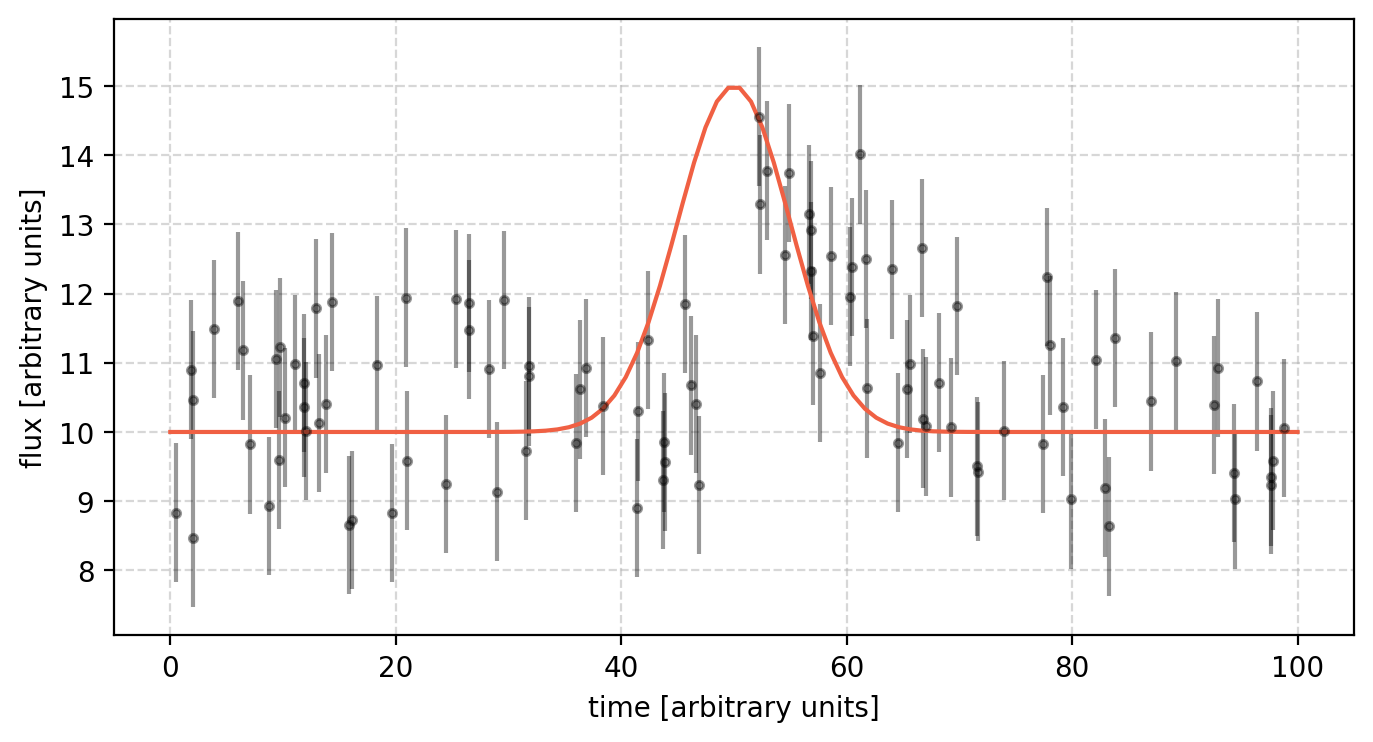

In [20]:
fig = plt.figure(figsize = (8,4))
ax = fig.add_subplot(111)
xgrid = np.linspace(0, 100, 100)

ax.set_xlabel('time [arbitrary units]')
ax.set_ylabel('flux [arbitrary units]')
ax.errorbar(time, flux, yerr=errors, fmt=".", c='black', alpha=0.4)
ax.plot(xgrid, gauss_f(xgrid, par_guesses), color=c[3])

ax.grid(True, ls='--', alpha=0.5)

$$\ln{L} = \ln\Big(\frac{1}{\sqrt{2\pi\sigma^2}}\Big) - \frac{1}{2}\sum_{i=1}^{N} \frac{(y_i - M(t_i,\theta))^2)}{\sigma^2} = -\frac{1}{2}\ln{(2\pi\sigma^2)} - \frac{1}{2}\sum_{i=1}^{N} \frac{(y_i - M(t_i,\theta))^2)}{\sigma^2}$$

In [21]:
#Prior ranges for 4 parameters:
a1, b1 = 0, 20 #b
a2, b2 = 0, 20 #A
a3, b3 = 30, 70 #t_0
a4, b4 = 0, 10 #sig_W

def transform_prior(u):
    # Define the ranges for each parameter
    ranges = [(a, b) for a, b in zip([a1, a2, a3, a4], [b1, b2, b3, b4])]
    params = [a + (b - a) * ui for (a, b), ui in zip(ranges, u)]
    
    return params

def LogLikelihood_gauss(par): #Now we care about the normalizing constant!
    model = gauss_f(t, par)
    f = (1/sigma**2)*(data - model)**2 
    return (-0.5) * np.log(2*np.pi*sigma[0]**2) - 0.5 * np.sum(f) #I choose sigma[0] since errors are all the equal!

def LogLikelihood_burst(par): #Now we care about the normalizing constant!
    model = burst_f(t, par)
    f = (1/sigma**2)*(data - model)**2 
    return (-0.5) * np.log(2*np.pi*sigma[0]**2) - 0.5 * np.sum(f)

### Bayesian evidence - Gaussian model

In [22]:
import dynesty

sampler = dynesty.NestedSampler(LogLikelihood_gauss, transform_prior, ndim)
sampler.run_nested()
sresults = sampler.results

6290it [00:07, 847.95it/s, +500 | bound: 30 | nc: 1 | ncall: 41081 | eff(%): 16.732 | loglstar:   -inf < -53.381 <    inf | logz: -65.235 +/-  0.154 | dlogz:  0.001 >  0.509]


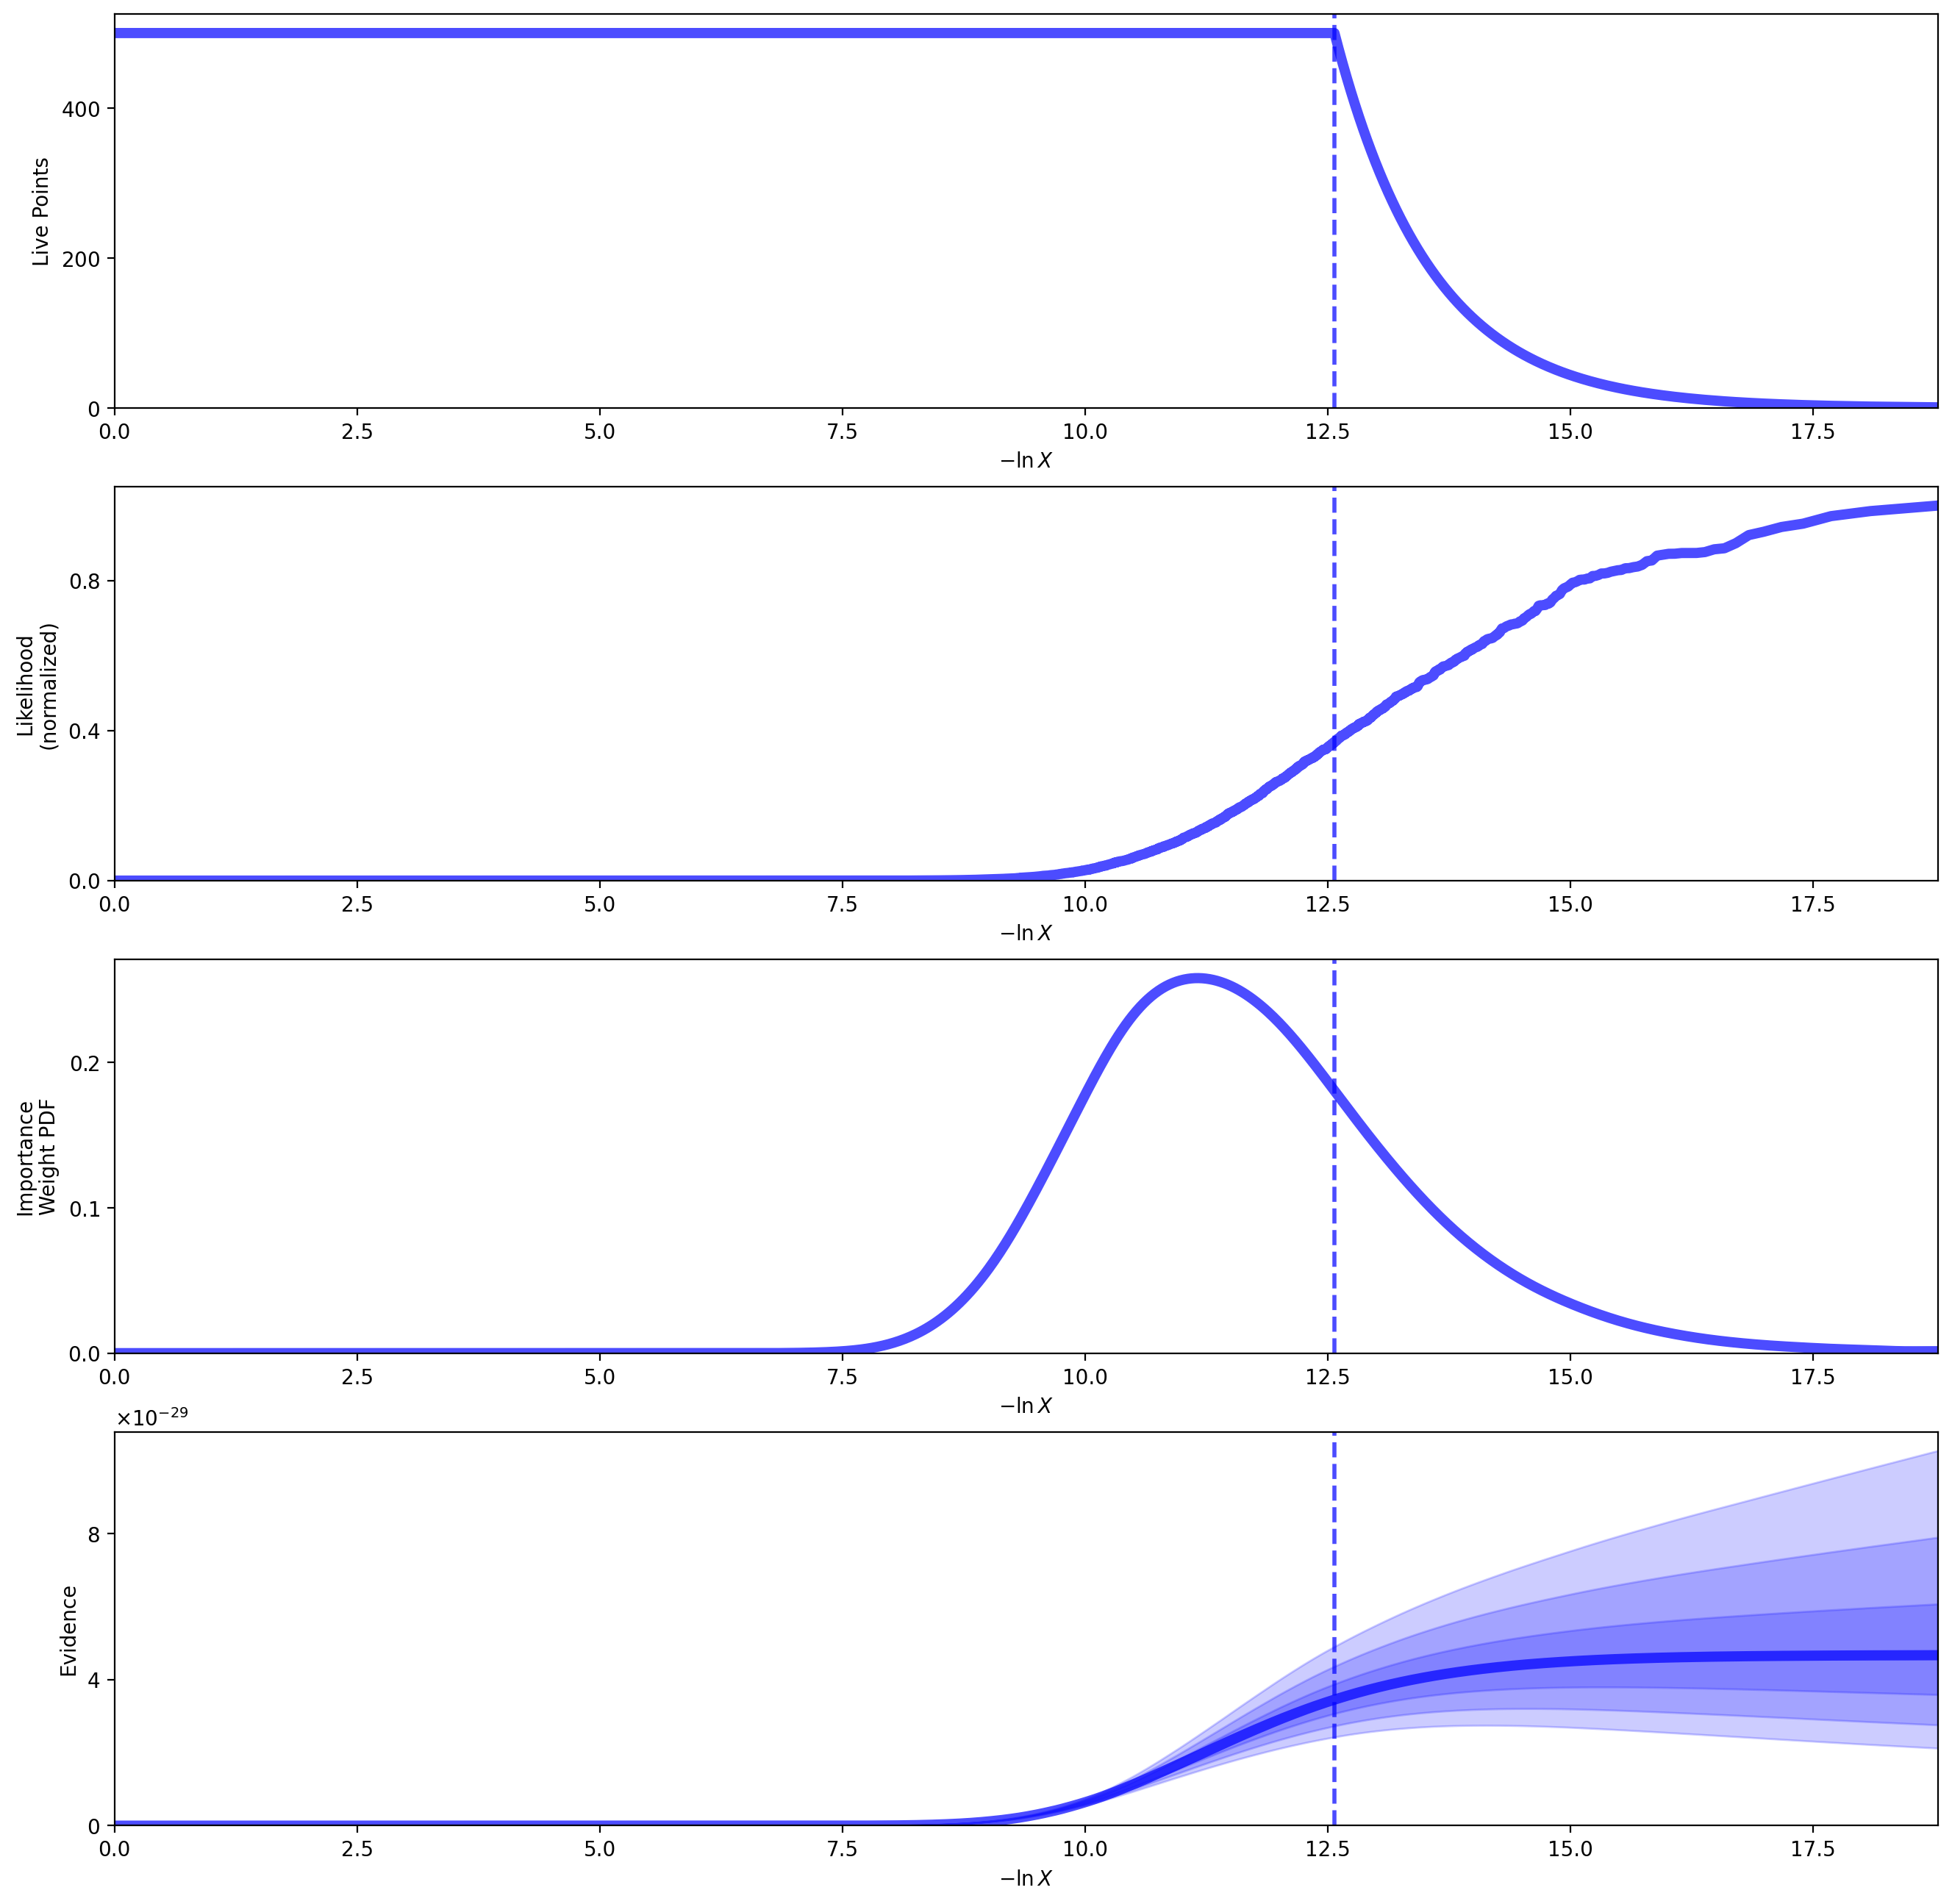

In [23]:
from dynesty import plotting as dyplot

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)

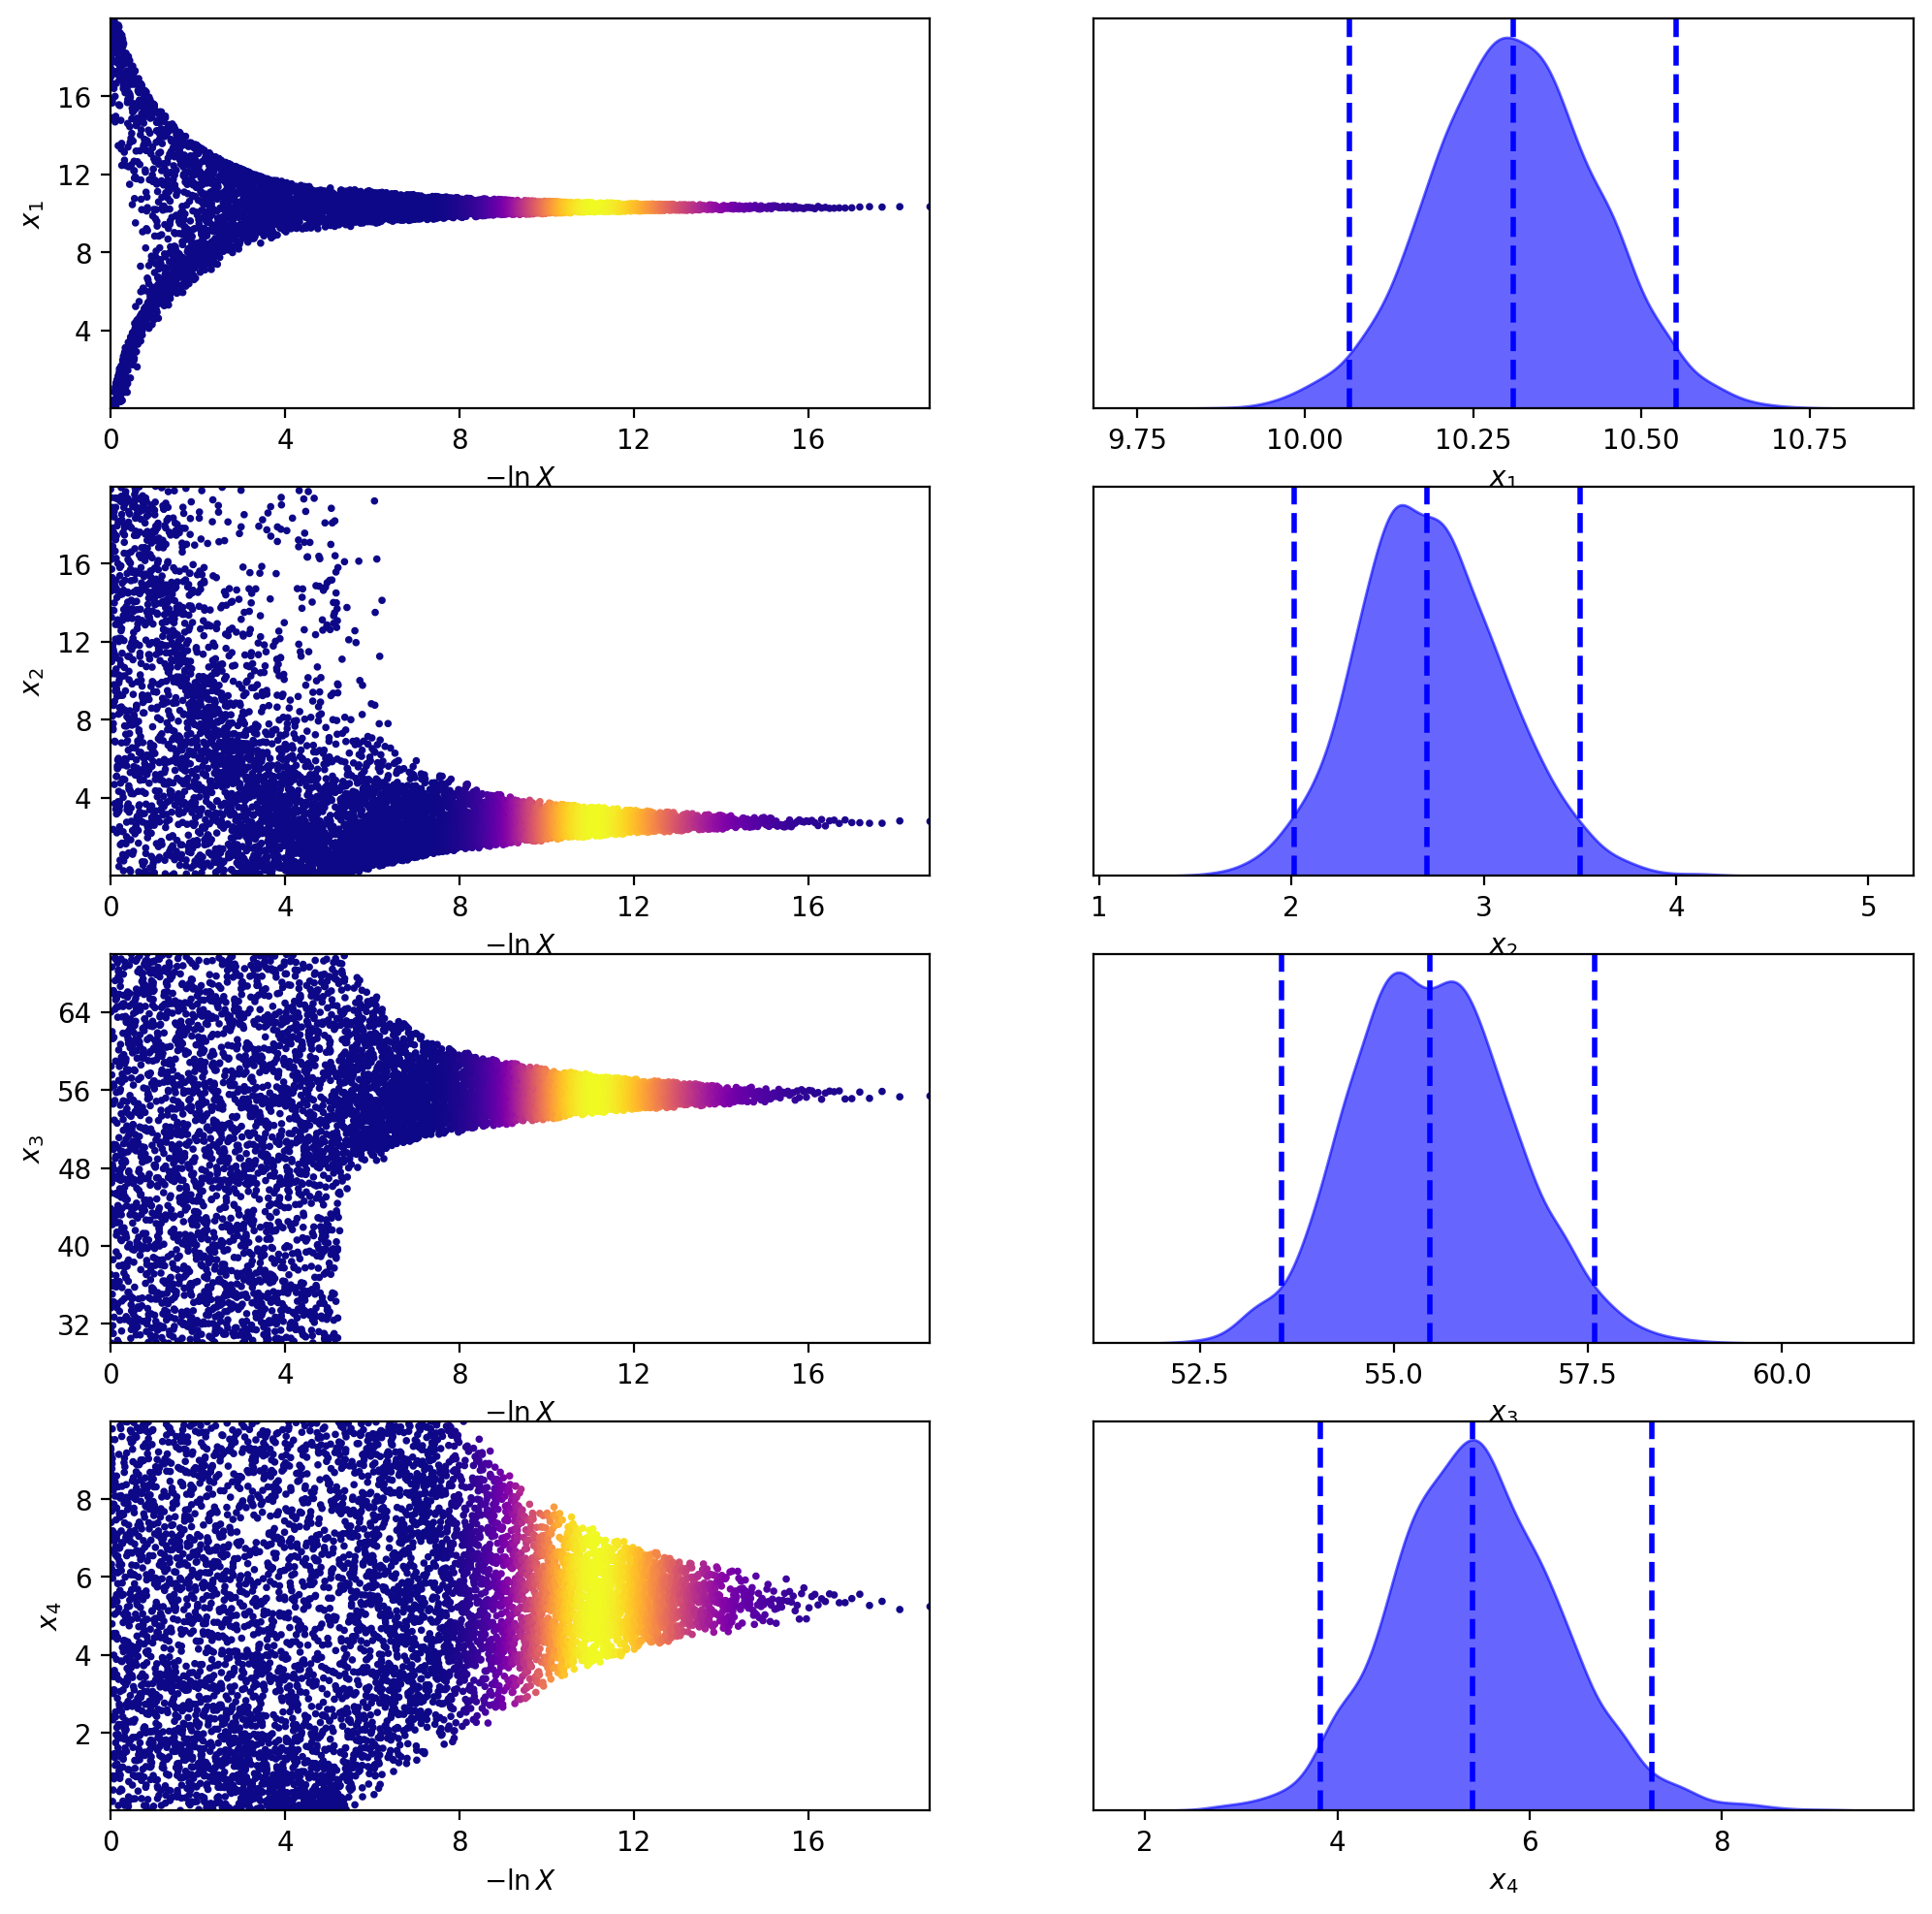

In [24]:
tfig, taxes = dyplot.traceplot(sresults)

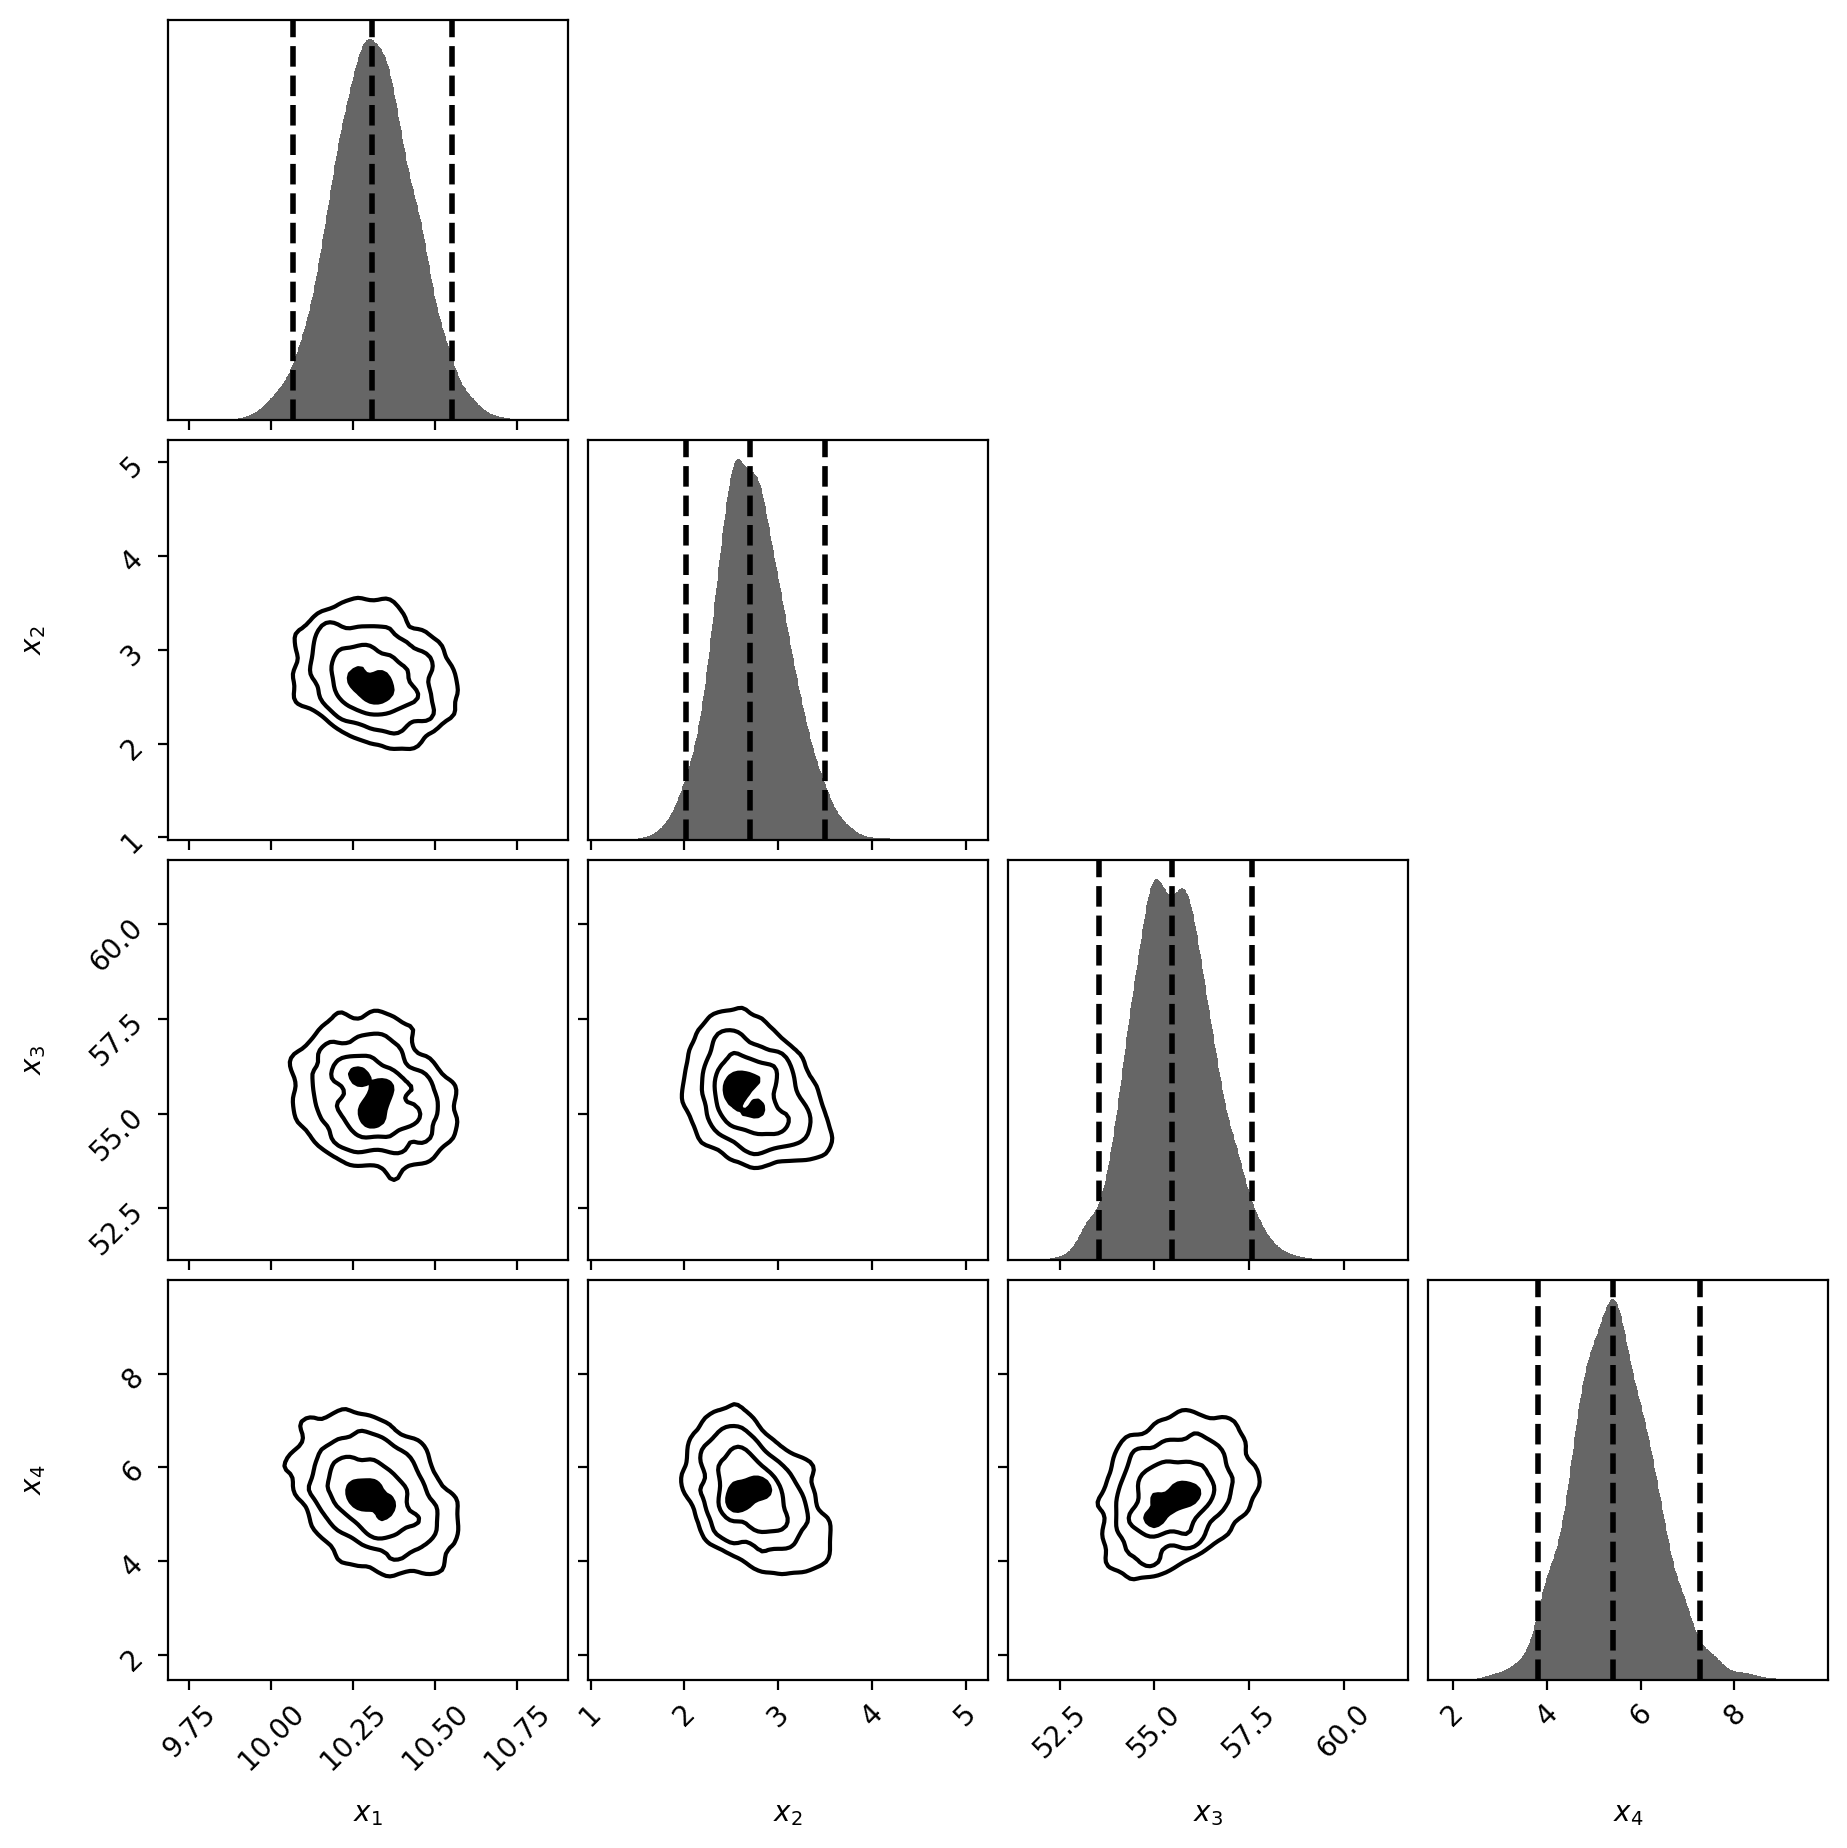

In [25]:
cfig, caxes = dyplot.cornerplot(sresults)

In [39]:
from dynesty import utils as dyfunc

# Extract sampling results.
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights

evidence_gauss = np.exp(sresults.logz[-1]) #evidence
print("Bayesian evidence", evidence_gauss)

quantiles = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights)
             for samps in samples.T]
print('68% parameter credible regions are:\n ' + str(quantiles) + '\n')

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and covariance of parameters are: \n' + str(mean) + '\n\n' + str(cov))

# Resample weighted samples.
samples_equal = dyfunc.resample_equal(samples, weights)

Bayesian evidence 4.6663202872531686e-29
68% parameter credible regions are:
 [[10.189395674535705, 10.436700156335363], [2.3629991697686616, 3.0988744346702144], [54.464449068323326, 56.51431924651088], [4.593192921179512, 6.293086489408176]]

Mean and covariance of parameters are: 
[10.31022647  2.7234279  55.49289243  5.43918247]

[[ 0.01539943 -0.00963492 -0.02358217 -0.0406552 ]
 [-0.00963492  0.14208483 -0.12071196 -0.13765763]
 [-0.02358217 -0.12071196  1.0555524   0.2894135 ]
 [-0.0406552  -0.13765763  0.2894135   0.77912833]]


NB: remember to downweight your samples before using `corner`. **dynesty** yields weighted samples. If you use dynesty tool for corner plots this is not necessary.

### Bayesian evidence - burst model

NB: We've used the same prior function even if now the 4th parameter has changed. Using the original prior $(e^{-5}, e^5)$ results in overflow errors with `dynesty`.

MCMC gives an estimate for $\alpha$ of 0.12, so $(0, 10)$ is still a reasonable prior. 

In [27]:
sampler_2 = dynesty.NestedSampler(LogLikelihood_burst, transform_prior, ndim)
sampler_2.run_nested()
sresults_2 = sampler_2.results

7370it [00:24, 300.10it/s, +500 | bound: 113 | nc: 1 | ncall: 102763 | eff(%):  7.696 | loglstar:   -inf < -49.710 <    inf | logz: -63.661 +/-  0.165 | dlogz:  0.001 >  0.509]


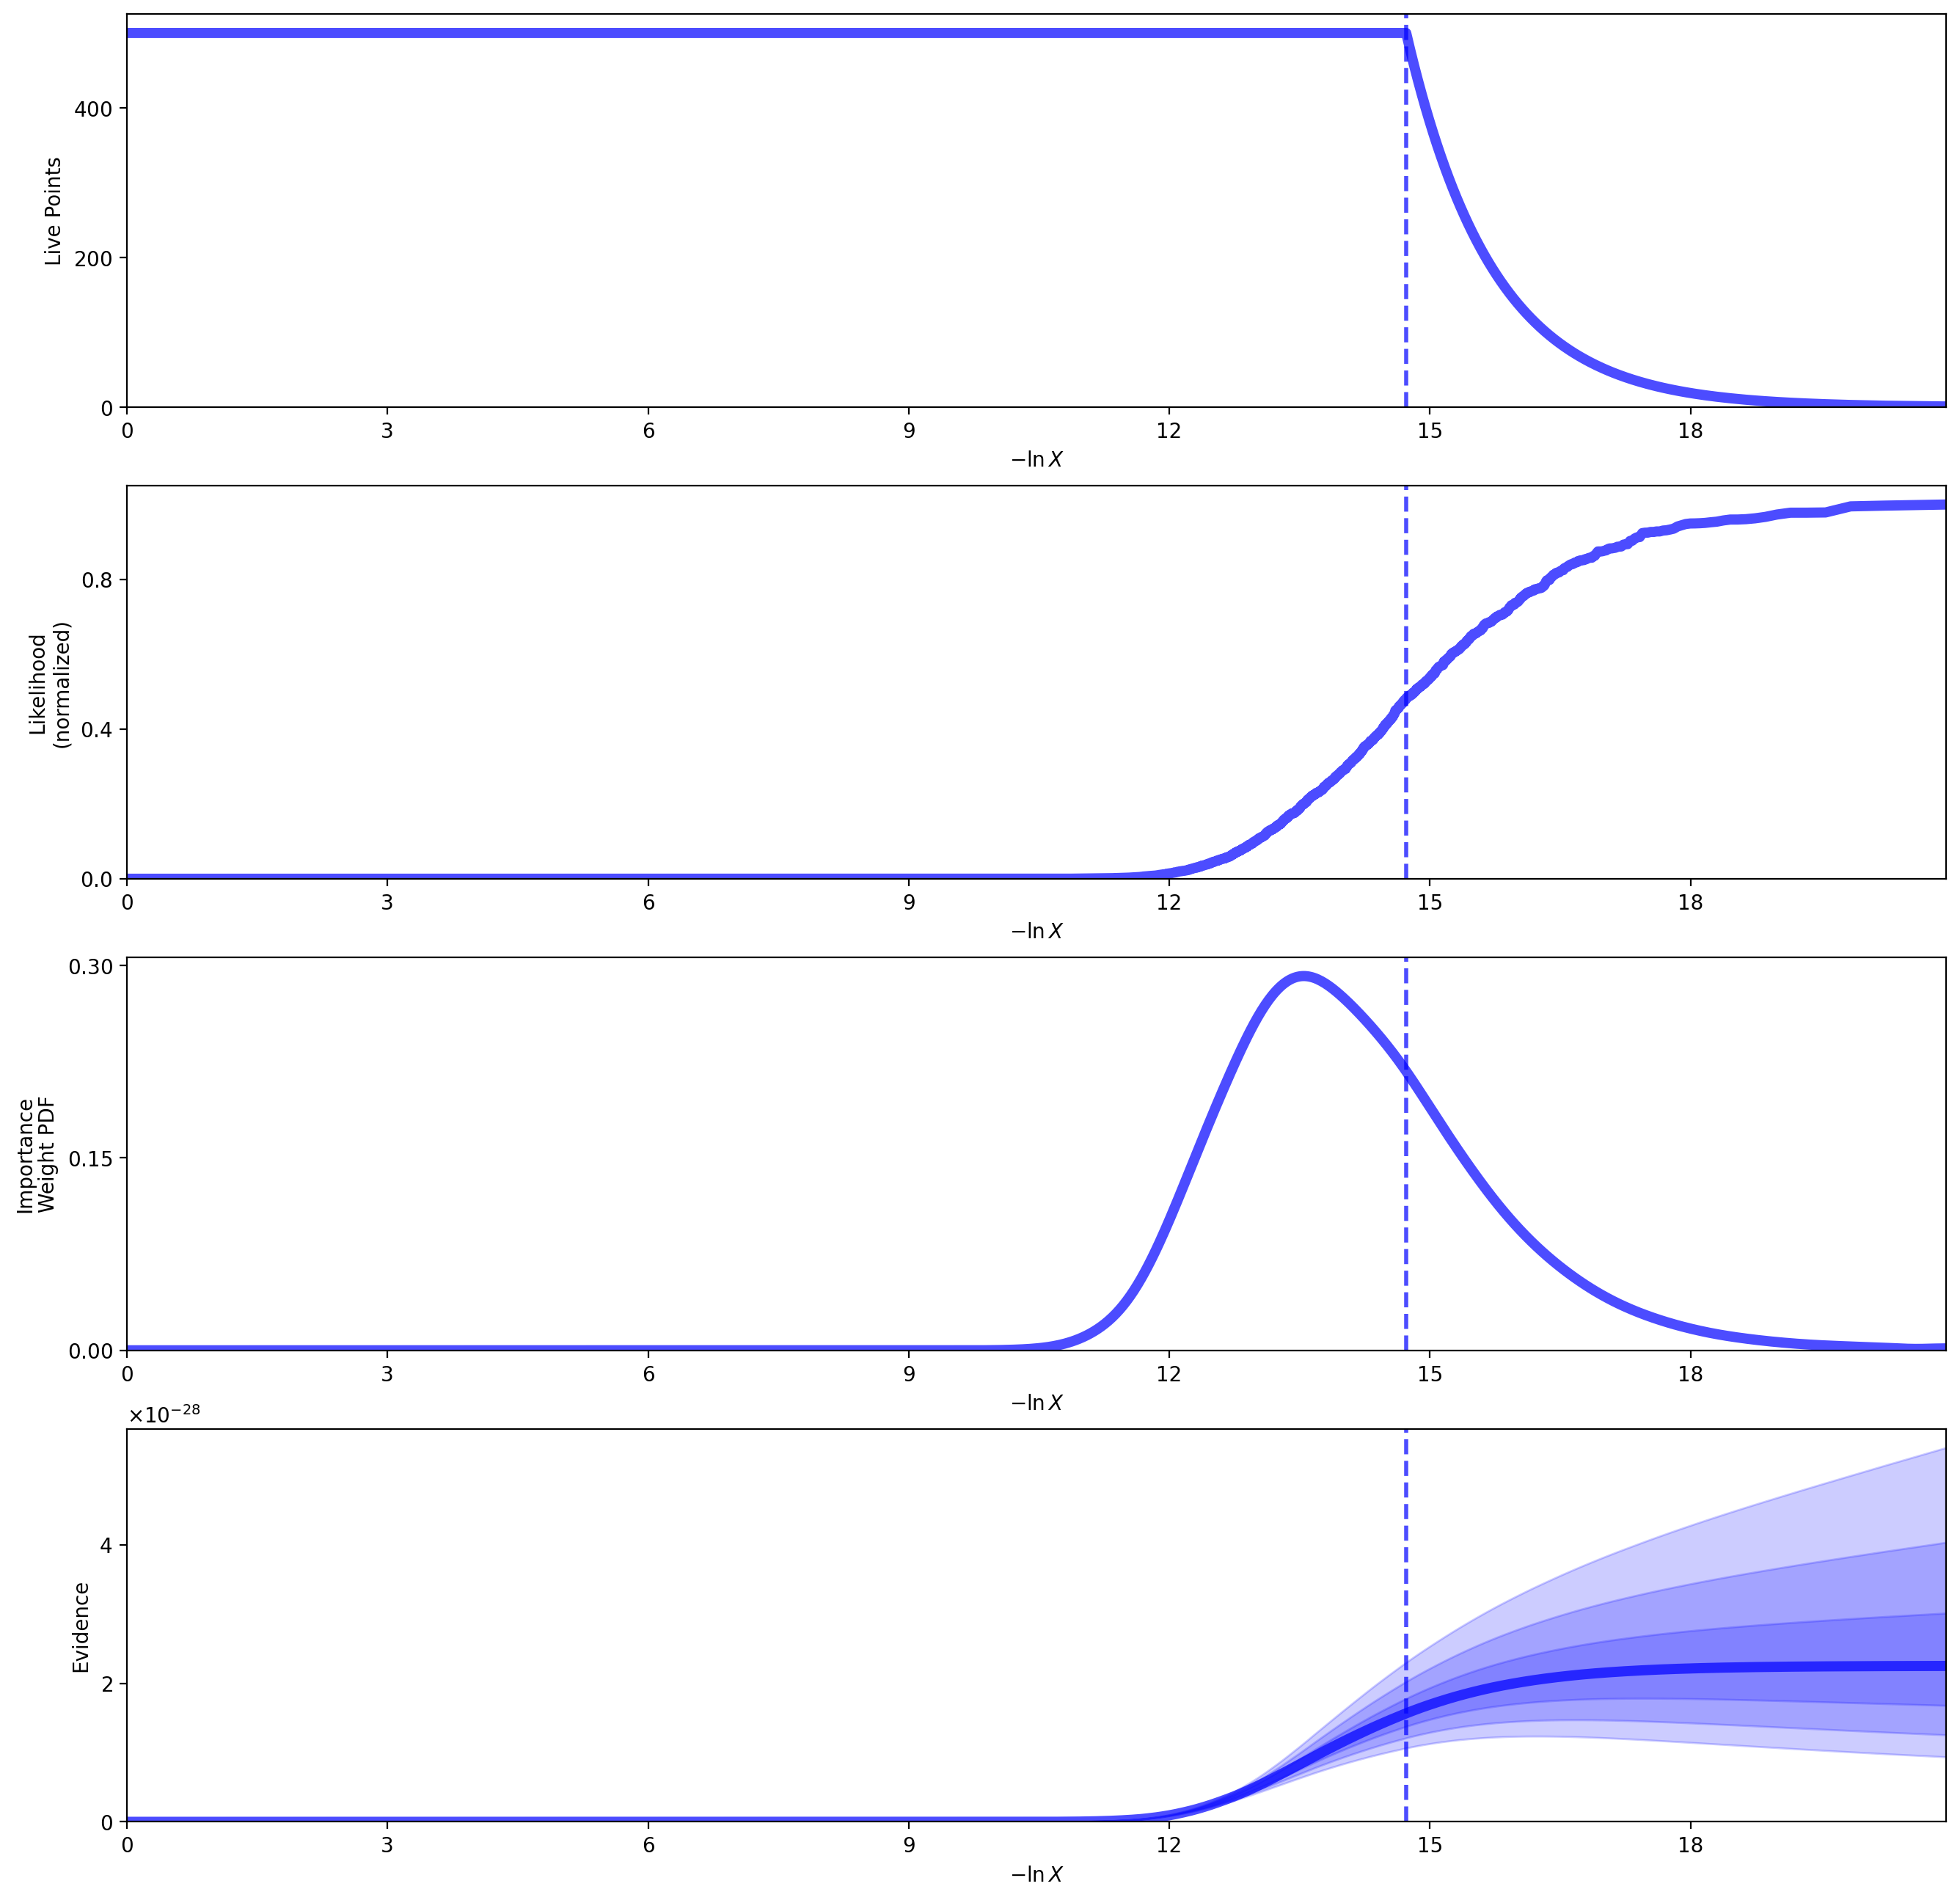

In [28]:
rfig, raxes = dyplot.runplot(sresults_2)

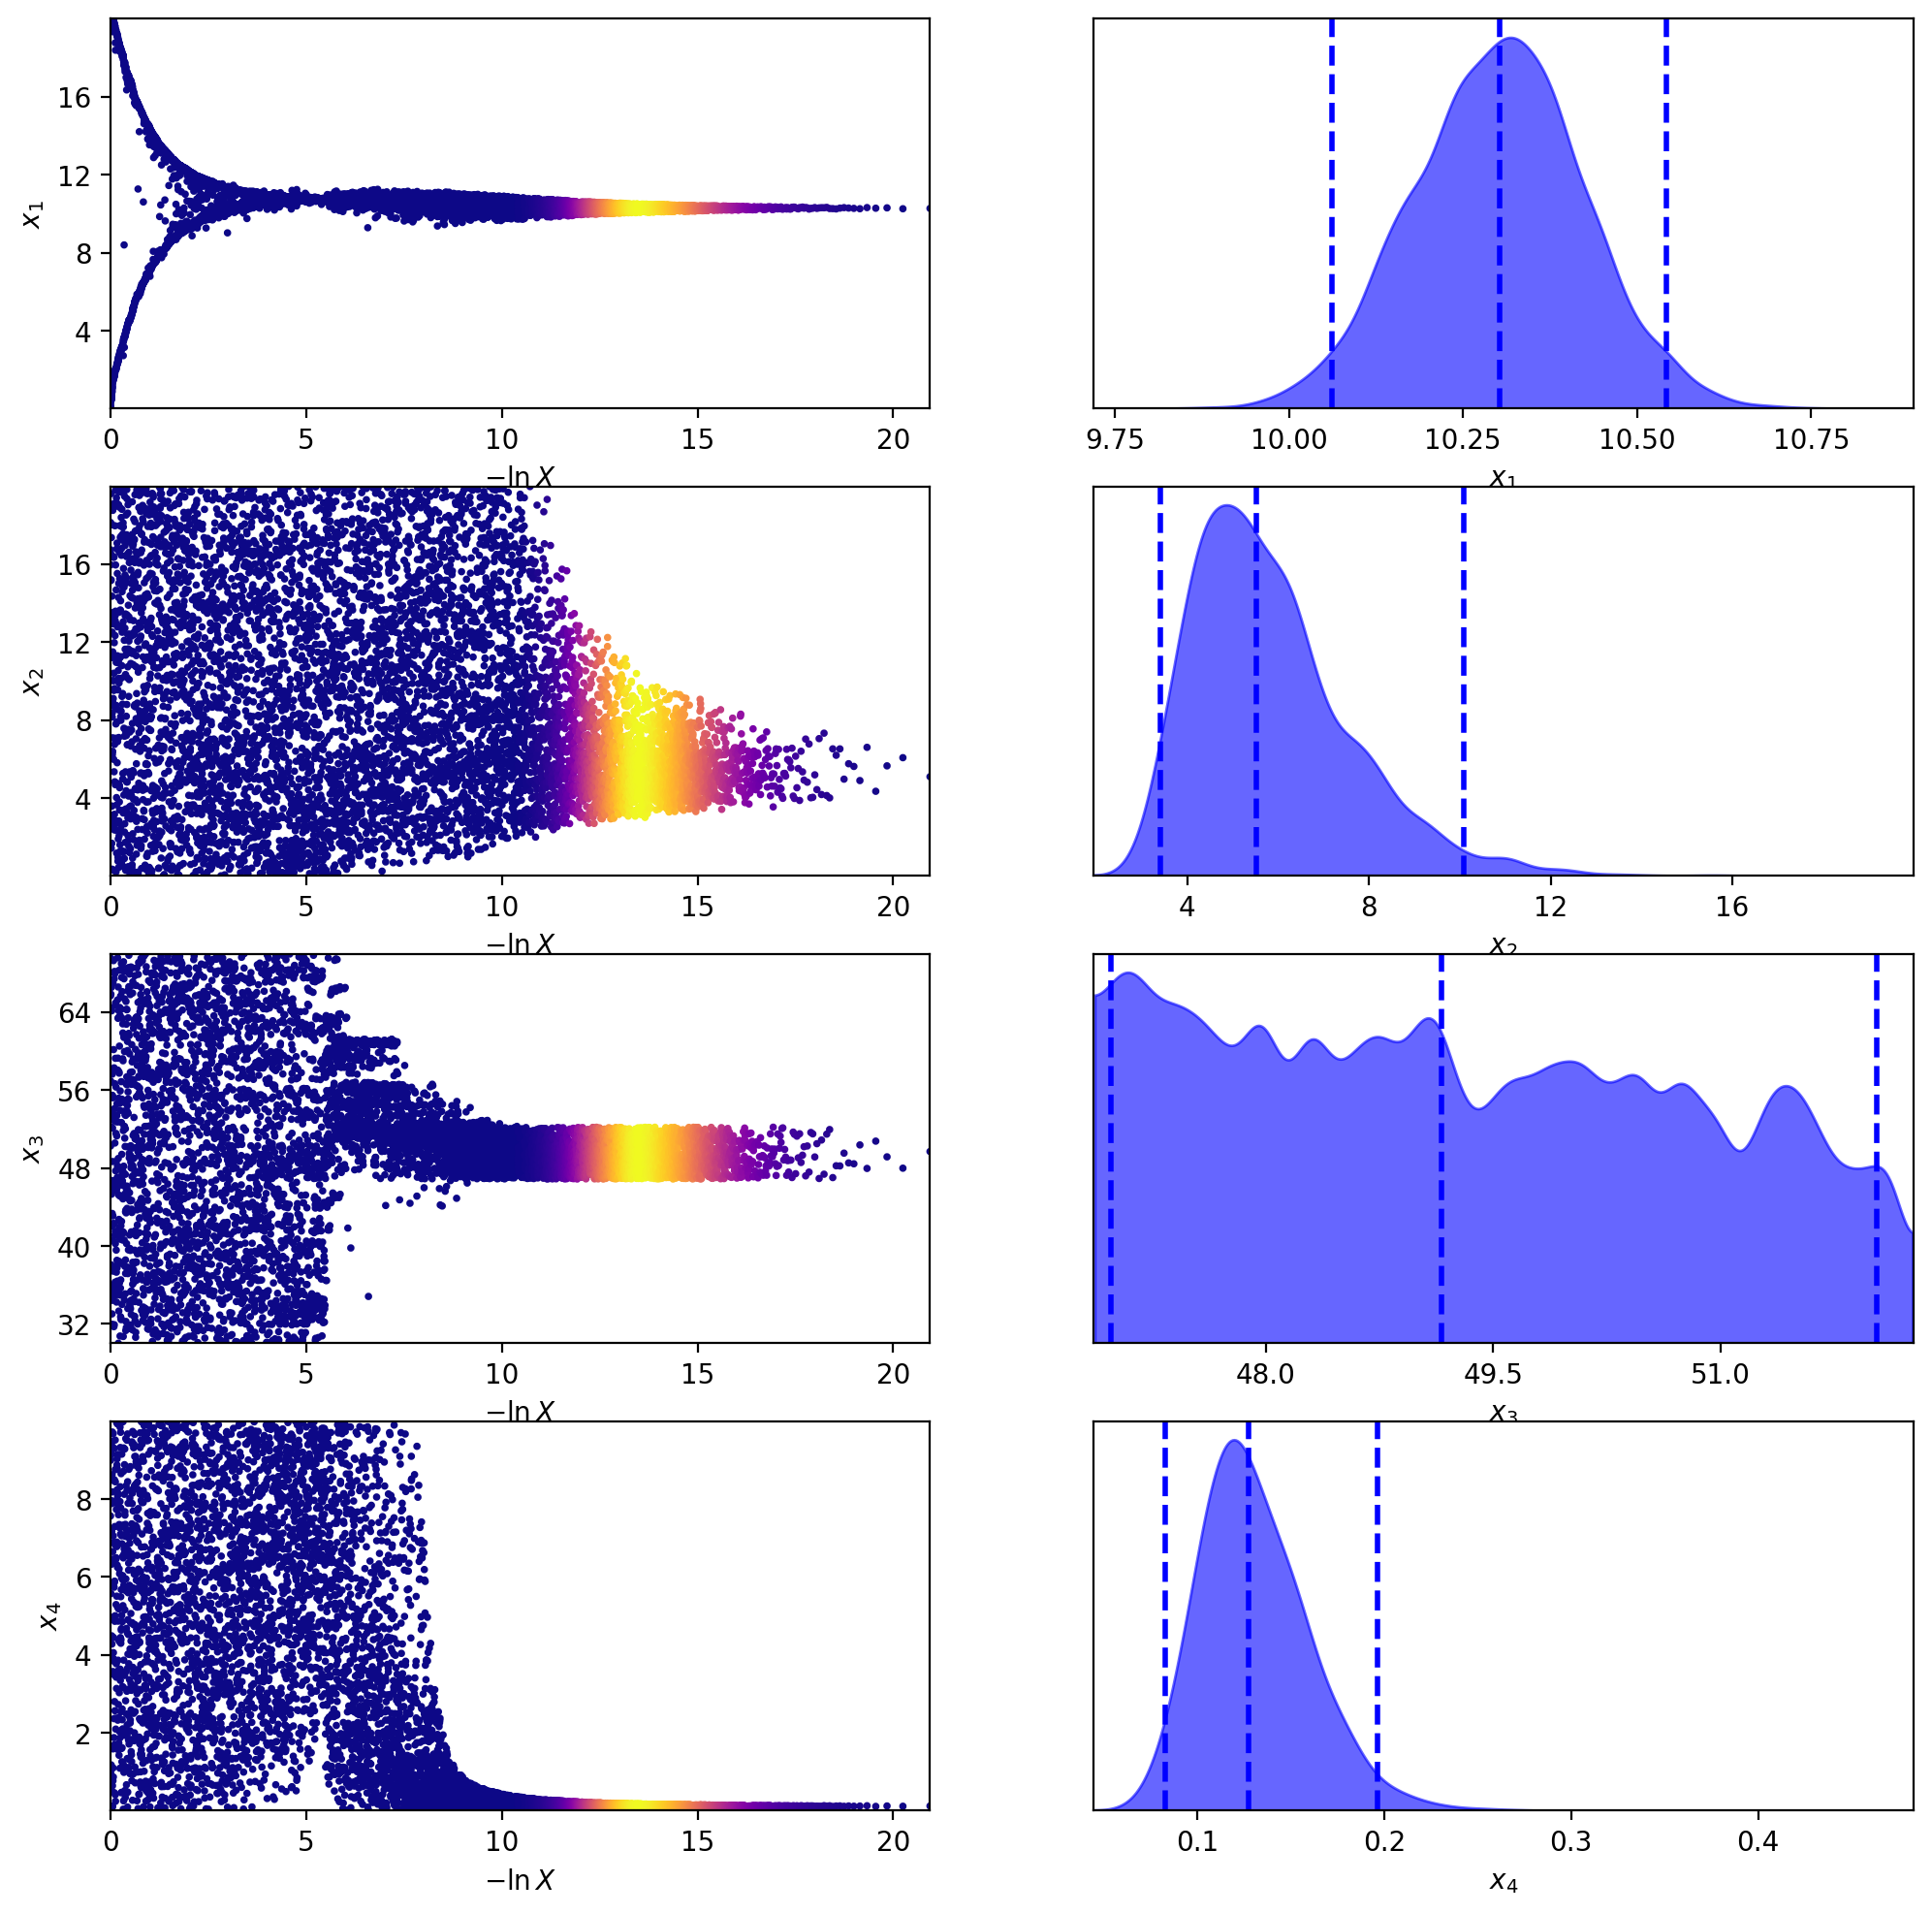

In [29]:
tfig, taxes = dyplot.traceplot(sresults_2)

In [30]:
evidence_burst = np.exp(sresults_2.logz[-1]) #evidence
print("Bayesian evidence of burst model is:", evidence_burst)

Bayesian evidence of burst model is: 2.250248053477756e-28


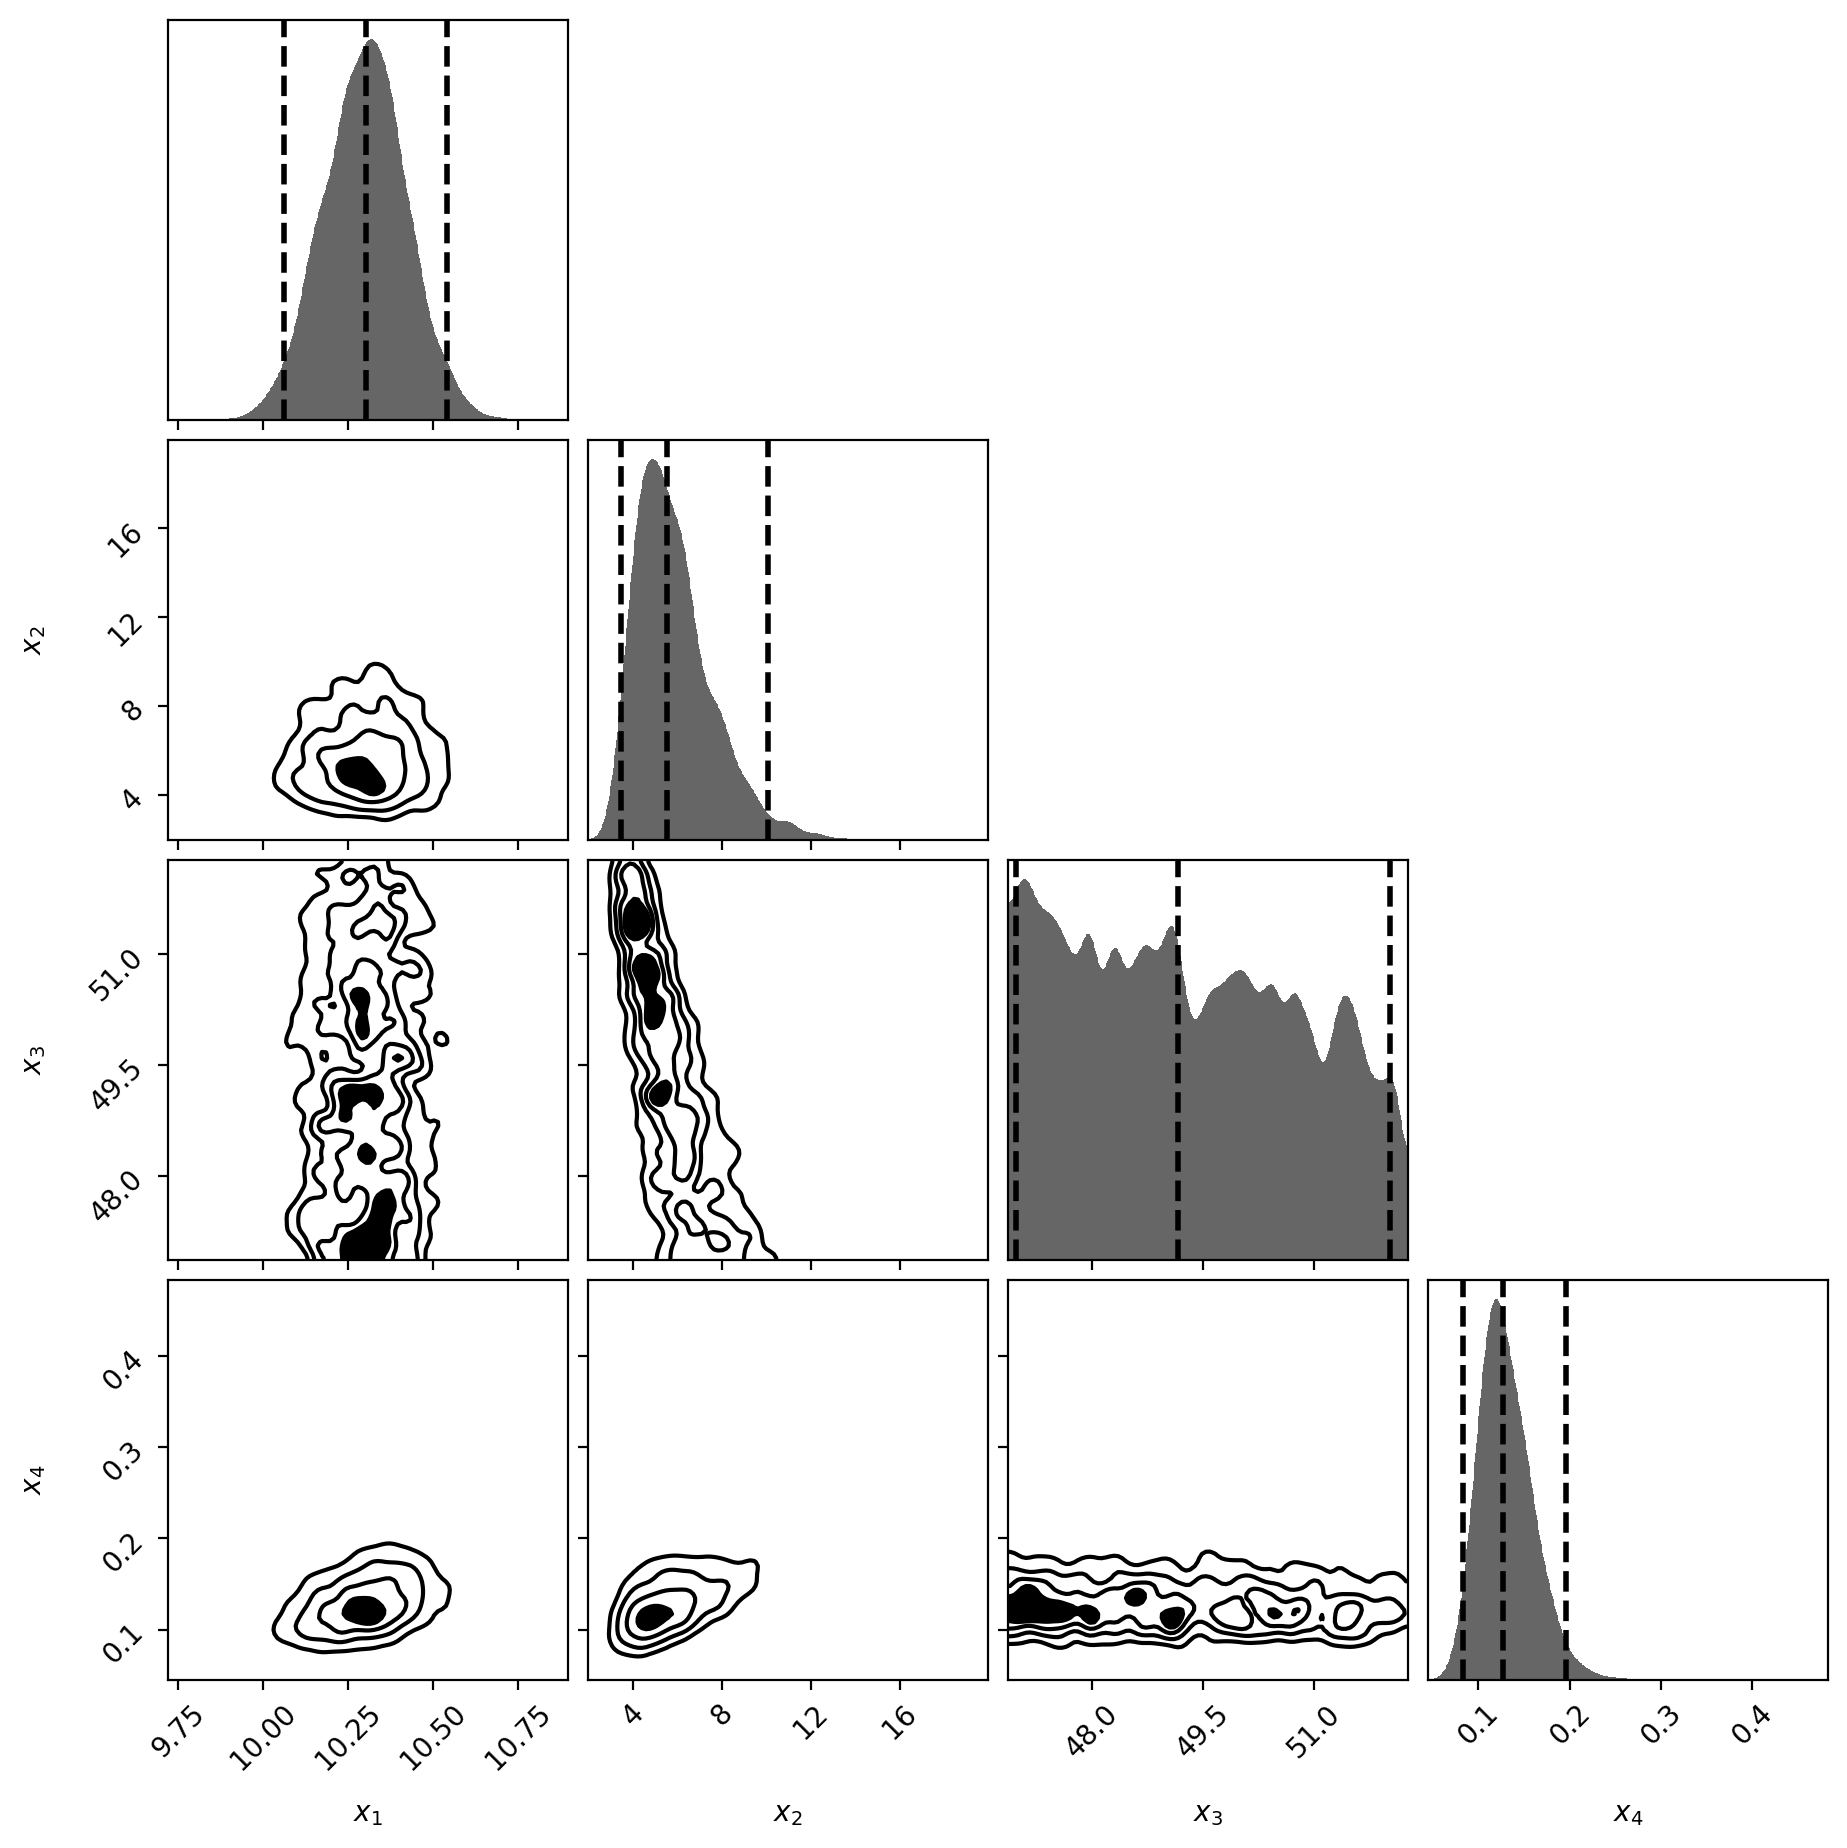

In [31]:
cfig, caxes = dyplot.cornerplot(sresults_2)

We notice that the `corner` plot for the **burst model** is qualitatively similar to the one we obtained using MCMC sampling.

### Bayes factor estimation
Assuming:
- Model 1: Burst
- Model 2: Gaussian

We can estimate the Bayes factor $\mathcal{B}_{12}$ to perform a model selection:

$$\mathcal{B}_{12} = \frac{\mathcal{Z}_1}{\mathcal{Z}_2} $$

In [32]:
B_12 = evidence_burst/evidence_gauss
B_12

4.8223180471016605

In [33]:
np.log(B_12)

1.5732547350914812

According to Jeffreys scale, a Bayes factor such that $1.1 < \ln{\mathcal{B_{12}}} < 2.3$ is sign of a *substantial* preference for model 1 over model 2. Thus we can conclude that the favored description of our data is given by the **burst model**.

In [34]:
sresults.summary()

Summary
nlive: 500
niter: 6290
ncall: 40581
eff(%): 16.732
logz: -65.235 +/-  0.263


In [35]:
sresults_2.summary()

Summary
nlive: 500
niter: 7370
ncall: 102263
eff(%):  7.696
logz: -63.661 +/-  0.292
